# Neural Demapper Training and TensorRT Export

![Neural Demapper Basics](../../figs/tutorial_nn_demapper_basic.png)
   
This first part of the tutorial covers training and implementation of a neural network (NN) based demapper using Sionna. We keep the neural network architecture straightforward to focus on efficient inference and the integration in the OAI stack.
 
While we use demapping as our example since it is a simple and well-understood task, neural networks could potentially replace many signal processing blocks like channel estimation or equalization.
The main focus here is demonstrating how to integrate neural network (NN) components into the physical layer's signal processing pipeline.

An important aspect is that OAI does not provide an estimate of the noise variance as required for *textbook*-style a posteriori probability (APP) demappers but provides a scaled version of the magnitude of the channel estimates. This will be explained in the following.


## Python Imports

In [ ]:
# Import the required libraries
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Set the TF log level to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf

# Import Sionna
import sionna as sn

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For saving complex Python data structures efficiently
import pickle

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

# For ONNX / TensorRT export
import tf2onnx
import onnx

# Set seed for reproducible results
sn.phy.config.seed = 42

## Background: APP-Demapping

We assume a sequence of `modulation order` bits $b$ which are mapped to a complex-valued QAM symbol. At the receiver, a noisy version of this symbol $y$ is observed and the task of the demapper is to calculate the individual a posteriori probabilities (APP) that each bit was 0 or 1.

In this tutorial, we will use 16-QAM modulation as example. While the demapper can be extended to other modulation orders in a straightforward manner, we focus on 16-QAM for clarity.
Note that with Gray-labeling, it is possible to use a higher-order demapper (e.g., 64-QAM) to demap lower-order modulations (e.g., 16-QAM) by discarding unused bits. However, this introduces unnecessary computational complexity and is not explored in this tutorial.


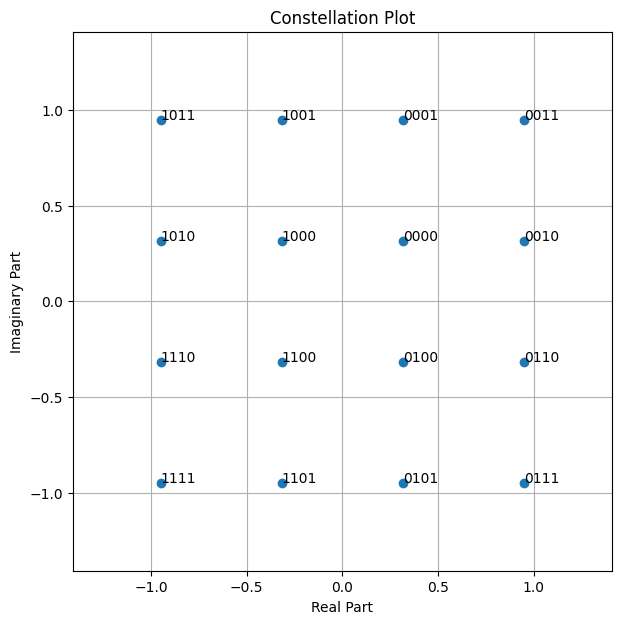

In [2]:
# Let's visualize all possible symbols for a 16-QAM
NUM_BITS_PER_SYMBOL = 4
mapper = sn.phy.mapping.Mapper(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                           constellation_type="qam")
demapper = sn.phy.mapping.Demapper(demapping_method="app",
                               num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                               constellation_type="qam")
mapper.constellation.show();

The above constellation diagram uses Gray labeling as used in the 5G standard.

After transmission over a noise channel the received symbols can be visualized.

In [3]:
# Binary source to generate uniform i.i.d. bits
binary_source = sn.phy.mapping.BinarySource()

# AWGN channel
awgn_channel = sn.phy.channel.AWGN()

BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel
EBN0_DB = 17.0 # Eb/N0 in dB

no = sn.phy.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE, 1200]) # Blocklength
x = mapper(bits)
y = awgn_channel(x, no)


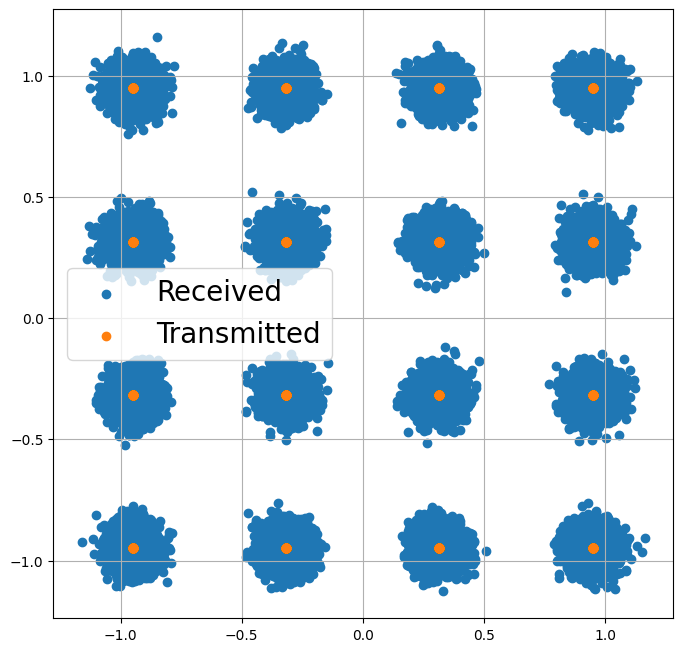

In [4]:
# Let's visualize the received symbols
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label='Received')
plt.scatter(tf.math.real(x), tf.math.imag(x), label='Transmitted')
plt.legend(fontsize=20);

The task of the demapper is now to calculate the a posterior probabilities (APP) $p(b_i=1|y)$ and $p(b_i=0|y)$ that the $i$-th bit was 0 or 1 given the received symbol $y$.
Typically, this is done by calculating log likelihood ratios (LLRs), i.e., logits instead of working in the probability domain.

For the $i$-th bit the LLR is defined as
$LLR(b_i) = \log[ \frac{p(b_i=1)}{p(b_i=0)}]$

One can show that the optimal APP demapping rule for an AWGN channel and the $i$-th bit can be computed as
        $$LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert y\right)}{\Pr\left(b_i=0\lvert y\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)$$

Note that simplifications such as *max-log* demapping exist.

From the above equation, we see that the neural demapper requires the received complex-valued symbol $y$ and the noise variance $N_0$ as input. It returns `modulation order` LLRs. We can use the Sionna APP demapper as a reference implementation to verify the performance of the neural demapper.

In [5]:
bits = np.array([[0,0,0,1]])
print("Original bits:", bits)
x = mapper(bits)
print("Complex-valued symbol:", x.numpy())
# Add some noise
no = 0.05 # Noise variance
y = awgn_channel(x, no)
print("Received noisy symbol: ", y.numpy())
llr = demapper(y, no)
print("LLRs after demapping:", llr.numpy())


Original bits: [[0 0 0 1]]
Complex-valued symbol: [[0.31622776+0.94868326j]]
Received noisy symbol:  [[0.6098989+0.91612023j]]
LLRs after demapping: [[-15.877348  -30.353184   -0.5706413   7.1762133]]


If the sign of the LLR is positive, the value of the associated bit is more likely a "1".
Consequently, negative LLRs are associated to a bit value of "0". The magnitude of the LLRs represents their reliability.
This soft-information can be used by the forward error correction (FEC) decoder to recover from transmission errors.

The above equations are the optimal demapping rule for an AWGN channel. However, implementing the optimal demapper for unknown channels remains a challenge.

## Understanding the OAI Data Structure

Before we can start to train our neural demapper, we need to understand the OAI data structure and align the Sionna setup for training.
For this, we use the captured data from the [previous tutorial](../data_acquisition/index.rst).

In [6]:
import sys
sys.path.append('../../')

MAX_LINES = 1000000 # Stop after this many imported lines

# Depends on config that was used for data capture
fn_input = '../../logs/demapper_in.txt'
fn_output = '../../logs/demapper_out.txt'

# Read training data from data dump
def read_training_data(in_file, element_shape):
    with open(in_file) as f:
        lines = f.readlines()
    result = None
    i = 0
    while i < len(lines):
        try:
            i = lines.index('QAM16\n', i)
        except ValueError as e:
            break
        num = int(lines[i+1])
        #if num > 30:
        #    print(num)
        data = np.fromstring(' '.join(lines[i+2:i+2+num]), sep=' ', dtype=np.int16).reshape(num, *element_shape)
        if result is None:
            result = data
        else:
            result = np.concatenate((result, data))
        i += 2 + num
        if i>MAX_LINES:
            break
    return result

def int16_to_float16(symbols_i):
    return np.ldexp(symbols_i.astype(np.float32), -8).astype(np.float16)

def float16_to_int16(llrs_h):
    return np.rint(np.ldexp(llrs_h.astype(np.float32), 8)).astype(np.int16)

def norm_int16_to_float16(symbols_i, magnitudes):
    args = symbols_i.astype(np.float32)
    if magnitudes is not None:
        args = args / magnitudes.astype(np.float32)
    return np.ldexp(args, 7).astype(np.float16)

data_in = read_training_data(fn_input, (2, 2))
data_out = read_training_data(fn_output, (4,))
assert(data_in.shape[0] == data_out.shape[0])

print("data_in.shape: ", data_in.shape)
print("data_out.shape: ", data_out.shape)

print("First 5 input symbols:", data_in[0:5,:])
print("First 5 output symbols:", data_out[0:5,:])

data_in.shape:  (856554, 2, 2)
data_out.shape:  (856554, 4)
First 5 input symbols: [[[-13 -18]
  [ 28  28]]

 [[ 47  32]
  [ 28  28]]

 [[ 15 -18]
  [ 28  28]]

 [[ 17   9]
  [ 28  28]]

 [[ 40 -43]
  [ 27  27]]]
First 5 output symbols: [[-13 -18  15  10]
 [ 47  32 -19  -4]
 [ 15 -18  13  10]
 [ 17   9  11  19]
 [ 40 -43 -13 -16]]


OAI uses integer representations of the input/output symbols. It requires scaling to be compatible with Sionna. 

The second input values are the resulting channel estimation magnitudes and can be used for re-scaling.
After re-scaling, the QAM symbols are scaled such that the first decision boundary equals to 1.0, i.e., the QAM constellation does not have unit power.
We will now re-scale the recorded symbols and compare the resulting LLRs to the Sionna reference.

Avg. power after norm: 1.0407250648843098


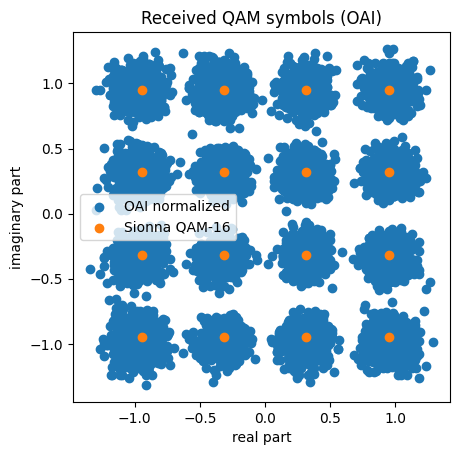

In [7]:
x = data_in[:10000,...]
# OAI uses h as decision region between inner and outer bits
# We scale the received symbols y back such that y_n = y / h
y_n = x[:,0,0]/x[:,1,0] + 1.j*x[:,0,1]/x[:,1,1]

# This normalizes the first decision bound to 1,
# i.e., the center between inner and out constellation points.
# In the Sionna definition (i.e., power normalized QAM),
# the inner/outer points are at 0.3162278 and 0.9486833, respectively.
# Thus we need to scale y_n by s = 0.9486833 - 0.3162278
s = 0.9486833 - 0.3162278 # outer - inner constellation point
y = y_n * s

# Calculate average power of received symbols after normalization
avg_power = np.mean(np.abs(y)**2)

# Keep in mind there is some noise variance
print("Avg. power after norm:", avg_power)

# And plot results
plt.scatter(y.real, y.imag, label="OAI normalized")
plt.title("Received QAM symbols (OAI)")
plt.ylabel("imaginary part")
plt.xlabel("real part");
plt.gca().set_aspect('equal', adjustable='box');

# Overlay with Sionna constellations
c = sn.phy.mapping.Constellation("qam", 4).points.numpy()
plt.scatter(c.real, c.imag, label="Sionna QAM-16")
plt.legend();

As can be seen, after normalization the received data symbols match well to the Sionna QAM constellation.

Using the Sionna demapper as reference allows to compare the calculated LLRs with the recorded dataset to verify that also the outputs are correctly scaled.
Note that OAI uses a heuristic demapper, i.e., the captured LLRs are not the ones we expect from APP demapping.

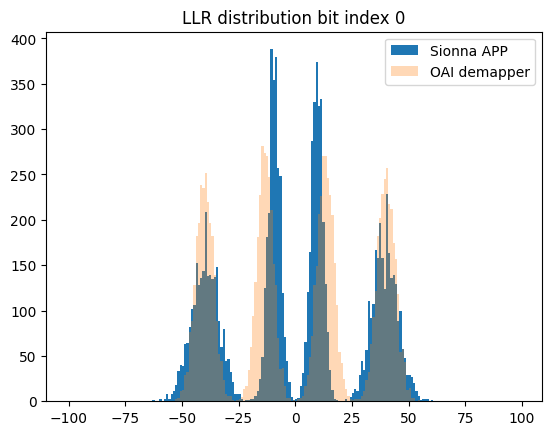

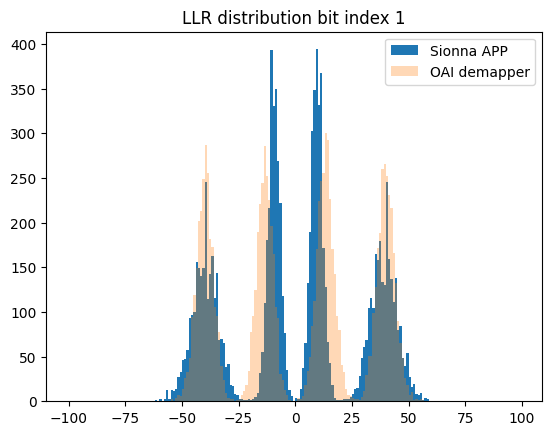

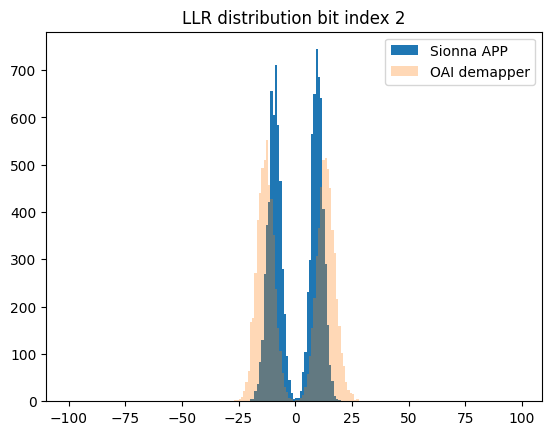

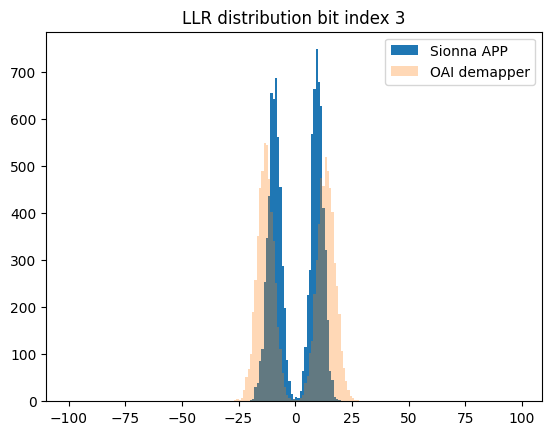

In [8]:
demapper = sn.phy.mapping.Demapper("app", "qam", 4)

y_tf = tf.constant(y, tf.complex64)
# avg_power is signal power ps + no where ps = 1
ps = 1. # Signal power
no = tf.constant(avg_power-ps, tf.float32)

llr = -1* demapper(y_tf, no) # Flip sign due to Sionna's logit definition

# Scale llrs
llr_ = llr.numpy()

llr_ref = np.reshape(llr_.astype(int), (-1,4))

llr_oai = data_out[:llr_ref.shape[0],...]

# And plot distributions
r = np.arange(-100, 100, 1)

for bit_idx in range(4):
    plt.figure()
    plt.hist(llr_ref[:,bit_idx], bins=r, label="Sionna APP")

    plt.hist(llr_oai[:,bit_idx], bins=r, alpha=0.3, label="OAI demapper")
    plt.legend();
    plt.title(f"LLR distribution bit index {bit_idx}")


The observed mismatch can be justified by the fact that OAI uses a heuristic demapper implementation.

The noise variance estimation itself is not available and the demapper must rely on the scaled channel magnitudes.

## Neural Demapper

The neural demapper must be operable with the OAI data structure as analyzed above. Further, we assume a fixed and static constellation, which means the network will learn the Gray labeling implicitly from the training data.

For this implementation, we create a simple neural demapper using the *Keras* Model framework. The architecture consists of a basic 3-layer multilayer perceptron (MLP). While this architecture is intentionally kept simple for demonstration purposes, there is room for architectural optimization in real-world applications.

In [9]:
class NeuralDemapper(Model): # Inherits from Keras Layer

    def __init__(self, num_bits_per_symbol,):
        """Neural demapper using a simple 3-layer MLP

        Inputs
        ------
        [y_i, y_q] or [y_i, y_q, h_i, h_q]
            list of tensors:

        y_i: [batch_size, 1, 1], tf.float32
            Real part of the received IQ symbols.

        y_q: [batch_size, 1, 1], tf.float32
            Imaginary part of the received IQ symbols.

        optional:
        h_i: [batch_size, 1, 1], tf.float32
            Real part of the estimated channel magnitude.

        h_q: [batch_size, 1, 1], tf.float32
            Real part of the estimated channel magnitude.

        Outputs
        -------
        llr: [batch_size, num_bits_per_symbol], tf.float32
            LLRs for each bit of a symbol.

        """
        super().__init__()

        # We are using three layers, this is not optimized but also not needed for this project
        self.dense_1 = Dense(32, 'relu', name='dense_1')
        self.dense_2 = Dense(32, 'relu', input_shape=(32,), name='dense_2')

        # The last layer has no activation and therefore outputs logits, i.e., LLRs
        self.dense_3 = Dense(num_bits_per_symbol, None,
                             input_shape=(32,), name='dense_3')

    def call(self, inputs, training=None):

        # Supports either a list of inputs or already concatenated version
        nn_input = tf.concat(inputs, axis=-1) if isinstance(inputs, list) else inputs
        z = self.dense_1(nn_input, training=training)
        z = self.dense_2(z, training=training)
        llr = self.dense_3(z, training=training) # [batch size, 1, num_bits_per_symbol]

        return llr


As demapping is a binary classification task of the `modulation order` logits, we use the binary cross entropy (BCE) loss and average over the individual bits.

In [10]:
NUM_BITS_PER_SYMBOL = 4 # 16-QAM

# Init components
neural_demapper_synthetic = NeuralDemapper(NUM_BITS_PER_SYMBOL)

# Binary classification problem -> train on BCE loss
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Use ADAM optimizer
optimizer = tf.keras.optimizers.Adam(1e-2)

# Dummy run to init the Keras model
neural_demapper_synthetic([tf.ones((1,1)),tf.ones((1,1))])

neural_demapper_synthetic.summary()

Model: "neural_demapper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  96        
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  132       
                                                                 
Total params: 1284 (5.02 KB)
Trainable params: 1284 (5.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Blind Demapping & Training with Synthetic Data

To simplify the training procedure, we use synthetic training data from Sionna.

We draw random payload bits, map them to QAM symbol and simulate the transmission over an AWGN channel.
As this synthetic data generation procedure is so fast, we generate new training data in each iteration of the training loop.

As noise variance estimates are not available, we train the neural demapper with only two inputs (real and imaginary part of the received symbol, respectively).
This obviously does not allow to reproduce exact APP estimates, but intuitively the demapper learns an average noise variance over all possible input SNRs. Keep in mind that the LDPC decoder is implemented as *min-sum* decoder which is know to be robust against mis-scaling of the LLRs.

To improve the neural demapper performance, in the next section we introduce another version which is trained on recorded data from the OAI testbed.
This version takes as input also the channel estimates.


In [11]:
BATCH_SIZE = 1024
NUM_TRAINING_ITERATIONS = 10000

# Scaling factor for QAM symbols to be compatible with the OAI demapper
qam16_threshold_mag = 2 * 0.3162278

@tf.function(jit_compile=False)
def training_step():
    # we train with a randomized noise variance
    no = tf.random.uniform([BATCH_SIZE,1], minval=0., maxval=1.,
                           dtype=tf.float32)
    # Draw random bits
    bits = binary_source([BATCH_SIZE, NUM_BITS_PER_SYMBOL])

    # Map to QAM symbols
    x = mapper(bits)

    # Transmit over Gaussian channel
    y = awgn_channel(x, no)

    # Split real and imaginary part and scale back to OAI
    qxr = tf.math.real(y) * (1.0 / qam16_threshold_mag)
    qxi = tf.math.imag(y) * (1.0 / qam16_threshold_mag)

    llr = neural_demapper_synthetic([qxr, qxi], training=True)
    loss = bce(bits, -llr) # Note: OAI uses flipped logits definition
    return loss

# Training loop
for i in range(NUM_TRAINING_ITERATIONS):
    with tf.GradientTape() as tape:
        loss = training_step()
    gradient = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradient, tape.watched_variables()));
    # Print progress
    if i % 500 == 0:
        print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}")

I0000 00:00:1743700295.518774 2480569 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0/10000  Loss: 7.06E-01
500/10000  Loss: 4.17E-01
1000/10000  Loss: 4.25E-01
1500/10000  Loss: 4.32E-01
2000/10000  Loss: 4.40E-01
2500/10000  Loss: 4.26E-01
3000/10000  Loss: 4.36E-01
3500/10000  Loss: 4.27E-01
4000/10000  Loss: 4.45E-01
4500/10000  Loss: 4.29E-01
5000/10000  Loss: 4.41E-01
5500/10000  Loss: 4.45E-01
6000/10000  Loss: 4.24E-01
6500/10000  Loss: 4.27E-01
7000/10000  Loss: 4.29E-01
7500/10000  Loss: 4.17E-01
8000/10000  Loss: 4.18E-01
8500/10000  Loss: 4.22E-01
9000/10000  Loss: 4.26E-01
9500/10000  Loss: 4.27E-01


Let's have a look at the outputs after training.

In [12]:
bits = np.array([[0,1,1,1]])
print("Original bits:", bits)
x = mapper(bits)
print("Complex-valued symbol:", x.numpy())
# Add some noise
no = tf.constant([[0.4,]]) # Noise variance
y = awgn_channel(x, no)
print("Received noisy symbol: ", y.numpy())
print(y)
llr_ref = demapper(y, no)
llr_nn = -neural_demapper_synthetic([tf.math.real(y) / qam16_threshold_mag,
                                     tf.math.imag(y) / qam16_threshold_mag])
print("LLRs Reference:", llr_ref)
print("LLRs NRX :", llr_nn)

Original bits: [[0 1 1 1]]
Complex-valued symbol: [[0.94868326-0.94868326j]]
Received noisy symbol:  [[0.9949063-0.77518046j]]
tf.Tensor([[0.9949063-0.77518046j]], shape=(1, 1), dtype=complex64)
LLRs Reference: tf.Tensor([[-4.562538    3.3838053   1.1041325   0.36931008]], shape=(1, 4), dtype=float32)
LLRs NRX : tf.Tensor([[-3.5805306   2.8586419   1.3626295   0.46617085]], shape=(1, 4), dtype=float32)


As can be seen, the outputs of the neural demapper are close to the (optimal) Sionna reference APP-demapper. 

In [13]:
# Save weights for synthetic demapper
fn = "model/neural_demapper_weights_y2"

weights = neural_demapper_synthetic.get_weights()
with open(fn, 'wb') as f:
    pickle.dump(weights, f)

## Improved Demapping & Training with Captured Data

To improve the performance of the neural demapper, we now also take OAI's channel estimates into account. Thus, the demapper has two complex-valued inputs (i.e., 4 real-valued), the received symbol and the channel estimate. Both are scaled integers as described earlier. Note that the scaled channel estimates of OAI that are provided to the demapper share the same real and imaginary component. Thus, 3 inputs would be sufficient, but we keep the same data structure and feed 4 inputs to the neural demapper.

The following code snippets can be used to train with recorded data from the [previous tutorial](../data_acquisition/index.rst).

In case of real-world data, we can use the mean squared error (MSE) loss and interpret the task as a regression problem. In this case, the labels are the outputs of the OAI demapper. Note that this includes erroneous decisions in the training data. A better approach is to use the corrected labels either by transmitting a known sequence or by using the LDPC decoder for error correction [Schibisch2018]. However, this is beyond the scope of this tutorial.

In [14]:
###########################################################################
# The following code is only relevant if training is done on captured data!
###########################################################################

# Depends on config that was used for data capture
fn_input = '../../logs/demapper_in.txt'
fn_output = '../../logs/demapper_out.txt'

# Requires data dump from the previous tutorial
demapper_in_data = read_training_data(fn_input, (2, 2))
demapper_out_data = read_training_data(fn_output, (4,))
assert(demapper_in_data.shape[0] == demapper_out_data.shape[0])

print("Training data size: ", demapper_out_data.shape[0])



Training data size:  856554


In [15]:
# Regression loss for training on captured data
rge = tf.keras.losses.MeanSquaredError()

# Use ADAM optimizer
optimizer = tf.keras.optimizers.Adam(1e-2)

# Init new receiver
neural_demapper_capture = NeuralDemapper(NUM_BITS_PER_SYMBOL)

# Dummy run to init the Keras model
# Note that we now have 4 inputs as we do not scale automatically
neural_demapper_capture([tf.ones((1,4))])

neural_demapper_capture.summary()

Model: "neural_demapper_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  160       
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  132       
                                                                 
Total params: 1348 (5.27 KB)
Trainable params: 1348 (5.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
@tf.function(jit_compile=False)
def training_step():
    # Train on captured data
    if True:
        i = np.random.randint(0, demapper_in_data.shape[0] - BATCH_SIZE)
        llr_ref = demapper_out_data[i:i+BATCH_SIZE]
        y_no = demapper_in_data[i:i+BATCH_SIZE]

        llr_ref = int16_to_float16(llr_ref)
        y_no = int16_to_float16(y_no)

        llr = neural_demapper_capture(y_no.reshape(-1, 4), training=True)
        loss = rge(llr_ref, llr)
        return loss

# Training loop
for i in range(NUM_TRAINING_ITERATIONS):
    with tf.GradientTape() as tape:
        loss = training_step()
    gradient = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradient, tape.watched_variables()));
    # Print progress
    if i % 500 == 0:
        print(f"{i}/{NUM_TRAINING_ITERATIONS}  Loss: {loss:.2E}")

0/10000  Loss: 1.42E-01
500/10000  Loss: 1.50E-05
1000/10000  Loss: 7.88E-06
1500/10000  Loss: 5.17E-05
2000/10000  Loss: 1.25E-05
2500/10000  Loss: 2.97E-06
3000/10000  Loss: 1.49E-06
3500/10000  Loss: 1.22E-05
4000/10000  Loss: 7.39E-05
4500/10000  Loss: 1.31E-06
5000/10000  Loss: 1.01E-06
5500/10000  Loss: 1.81E-05
6000/10000  Loss: 6.59E-07
6500/10000  Loss: 6.77E-05
7000/10000  Loss: 4.81E-06
7500/10000  Loss: 1.07E-04
8000/10000  Loss: 3.10E-06
8500/10000  Loss: 1.40E-05
9000/10000  Loss: 4.12E-05
9500/10000  Loss: 7.80E-06


In [17]:
# Save weights of captured demapper
fn = "model/neural_demapper_weights_y4"

weights = neural_demapper_capture.get_weights()
with open(fn, 'wb') as f:
    pickle.dump(weights, f)

Note that this implementation of the demapper has four inputs instead of the two normalized inputs from the synthetic demapper.
However, due to the lack of ground truth information, the training data is only as good as the OAI heuristic demapper.

One could use the LDPC decoder to reconstruct improved labels as done in [Schibisch2018]. However, this is beyond the scope of this tutorial.

## Export TensorRT Engine

We can now export the model including its weights such that it can be loaded in [TensorRT](https://developer.nvidia.com/tensorrt).

TensorRT is a toolset to achieve high-performance deep learning inference. As input it requires the [ONNX](https://onnx.ai/) export of a trained model.

In [18]:
synthetic = True

if synthetic:
    num_inputs = 2  # 2xfloat16
else:
    num_inputs = 4  # 4xfloat16

fn = f"model/neural_demapper_weights_y{num_inputs}"

# Load weights via pickle
with open(fn, 'rb') as f:
    weights = pickle.load(f)
neural_demapper = NeuralDemapper(NUM_BITS_PER_SYMBOL)

# Dummy run to init layers
neural_demapper([tf.ones((1,num_inputs))])

# And load weights
neural_demapper.set_weights(weights)

We now convert the model to the ONNX file format and build the TensorRT engine.

Note that you may need to fix the `trtexec` path (requires restart the Jupyter notebook) via `export PATH=$PATH:/usr/src/tensorrt/bin`.

In [ ]:
bs_max = 512 # max batch size for inference

# We use dynamic shapes for the batch_dim
input_signature =[tf.TensorSpec([None,num_inputs], tf.float16, name="y")]


onnx_model, _ = tf2onnx.convert.from_keras(
    neural_demapper,
    input_signature=input_signature
)
onnx.checker.check_model(onnx_model)

# And save the ONNX model
onnx.save(onnx_model, f"model/neural_demapper.{num_inputs}xfloat16.onnx")

# And build trtengine
trt_command = f'/usr/src/tensorrt/bin/trtexec --fp16'
trt_command += f' --onnx=model/neural_demapper.{num_inputs}xfloat16.onnx'
trt_command += f' --saveEngine=model/neural_demapper.{num_inputs}xfloat16.plan'
trt_command += f' --preview=+profileSharing0806'
trt_command += f' --inputIOFormats=fp16:chw'
trt_command += f' --outputIOFormats=fp16:chw'

trt_command += f" --minShapes=y:1x{num_inputs}"
trt_command += f" --optShapes=y:{64}x{num_inputs}"
trt_command += f" --maxShapes=y:{bs_max}x{num_inputs}"

# And run the command
os.system(trt_command)

The TensorRT engine is now exported and can be used by the neural demapper plugin.
The next part of this tutorial will explain the CUDA integration of the engine.